In [1]:
# Imports (External)
import numpy as np
import pandas as pd
import datetime as dt
import xlrd
import xlsxwriter
from collections import OrderedDict
import copy

import sys
sys.path.append('../')  

# Visualization/plotting imports
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import pywt
from pywt import wavedec, waverec
import scipy
from scipy import signal
from statsmodels.robust import mad
from sklearn import preprocessing

# Internal Imports
from wsae_lstm.utils import dictmap_load,pickle_load,pickle_save
from wsae_lstm.models.wavelet import denoise_periods,waveletSmooth

In [2]:
plt.rcParams["figure.figsize"] = (10,6)

In [3]:
dict_dataframes_index=pickle_load(path_filename="../data/interim/cdii_tvt_split.pickle")
#ddi_denoised=pickle_load(path_filename="../data/interim/cdii_tvt_split_denoised.pickle")

In [4]:
dict_dataframes_index.keys()

dict_keys(['csi300 index data', 'nifty 50 index data', 'hangseng index data', 'nikkei 225 index data', 's&p500 index data', 'djia index data'])

In [5]:
#dict_dataframes_index['csi300 index data'][1][1].info()

In [6]:
#dict_dataframes_index['nifty 50 index data'][1][1].info()

In [7]:
#dict_dataframes_index['hangseng index data'][1][1].info()

In [8]:
# Normalization --> you must be able to accurately estimate the minimum and maximum observable values

#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler

# potential drop in of robust scaler over standard
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler


In [9]:
#scipy.sparse.issparse(dict_dataframes_index['csi300 index data'][1][1])

In [10]:
#dict_dataframes_index['nifty 50 index data'][1][1].hist();
#dict_dataframes_index['hangseng index data'][1][1].hist();

In [11]:
#dict_dataframes_index['nifty 50 index data'][1][1].hist();


In [12]:
X_train = dict_dataframes_index['nifty 50 index data'][1][1]
X_val = dict_dataframes_index['nifty 50 index data'][1][2]
X_test = dict_dataframes_index['nifty 50 index data'][1][3]

In [13]:
scaler = preprocessing.RobustScaler()
#scaler

In [14]:
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled,columns=list(X_train.columns))

X_val_scaled = scaler.transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled,columns=list(X_val.columns))

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled,columns=list(X_test.columns))

In [15]:
def denoise_periods(dict_dataframes):
    
    ddi_scaled = dict()
    ddi_denoised= dict() 
    for key, index_name in enumerate(dict_dataframes):
        ddi_denoised[index_name] = copy.deepcopy(dict_dataframes[index_name])
        ddi_scaled[index_name] = copy.deepcopy(dict_dataframes[index_name])
    for key, index_name in enumerate(ddi_denoised): 
        scaler = preprocessing.RobustScaler()

        for index,value in enumerate(ddi_denoised[index_name]):
            
            X_train = ddi_denoised[index_name][value][1]
            X_train_scaled = scaler.fit_transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled,columns=list(X_train.columns))
            
            X_val = ddi_denoised[index_name][value][2]
            X_val_scaled = scaler.transform(X_val)
            X_val_scaled = pd.DataFrame(X_val_scaled,columns=list(X_val.columns))
            
            X_test = ddi_denoised[index_name][value][3]
            X_test_scaled = scaler.transform(X_test)
            X_test_scaled = pd.DataFrame(X_test_scaled,columns=list(X_test.columns))
            
            ddi_scaled[index_name][value][1] = X_train_scaled
            ddi_scaled[index_name][value][2] = X_val_scaled
            ddi_scaled[index_name][value][3] = X_test_scaled
            
            ddi_denoised[index_name][value][1] = waveletSmooth(X_train_scaled)
            ddi_denoised[index_name][value][2] = waveletSmooth(X_val_scaled)
            ddi_denoised[index_name][value][3] = waveletSmooth(X_test_scaled)
            
    return ddi_scaled,ddi_denoised
ddi_scaled,ddi_denoised = denoise_periods(dict_dataframes_index)

In [16]:
len(ddi_denoised)

6

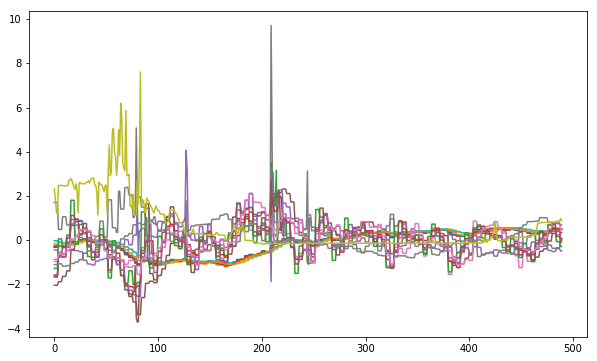

In [17]:
plt.plot(ddi_denoised['nifty 50 index data'][1][1]);

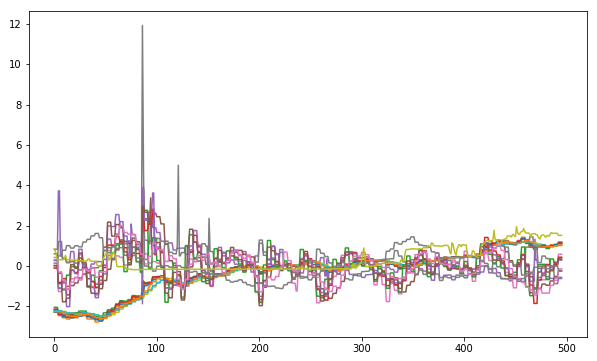

In [18]:
plt.plot(ddi_denoised['nifty 50 index data'][3][1]);

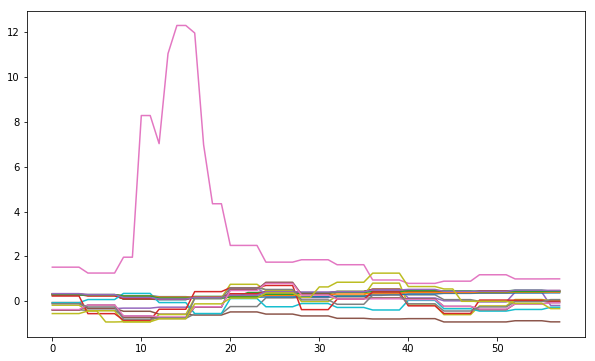

In [19]:
plt.plot(ddi_denoised['csi300 index data'][2][3]);

In [37]:
pd.DataFrame(ddi_denoised['djia index data'][5][3]).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.142476,0.179136,0.212879,0.075941,0.798801,-1.686815,-0.882567,2.311198,0.556478,0.452693,0.214445,0.263746,0.234215,-1.227669,-1.181644,-0.707196,-0.705320,0.144804,-1.250000
1,0.142476,0.179136,0.212879,0.075941,0.798801,-1.686815,-0.882567,2.311198,0.556478,0.452693,0.214445,0.263746,0.234215,-1.227669,-1.181644,-0.707196,-0.705320,0.144804,-1.250000
2,0.142476,0.179136,0.212879,0.075941,0.798801,-1.686815,-0.882567,2.311198,0.556478,0.452693,0.214445,0.263746,0.234215,-1.227669,-1.181644,-0.707196,-0.705320,0.144804,-1.250000
3,0.142476,0.179136,0.212879,0.075941,0.798801,-1.686815,-0.882567,2.311198,0.556478,0.452693,0.214445,0.263746,0.234215,-1.227669,-1.181644,-0.707196,-0.705320,0.144804,-1.250000
4,0.452098,0.518496,0.546209,0.454441,-0.367349,-0.989060,0.277503,1.020180,0.521594,0.487021,0.364894,0.328117,1.193483,-0.436869,-0.431540,0.443062,-0.149987,-0.160704,-1.285714


In [39]:
pd.DataFrame(ddi_denoised['djia index data'][5][3]).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 19 columns):
0     64 non-null float64
1     64 non-null float64
2     64 non-null float64
3     64 non-null float64
4     64 non-null float64
5     64 non-null float64
6     64 non-null float64
7     64 non-null float64
8     64 non-null float64
9     64 non-null float64
10    64 non-null float64
11    64 non-null float64
12    64 non-null float64
13    64 non-null float64
14    64 non-null float64
15    64 non-null float64
16    64 non-null float64
17    64 non-null float64
18    64 non-null float64
dtypes: float64(19)
memory usage: 9.6 KB


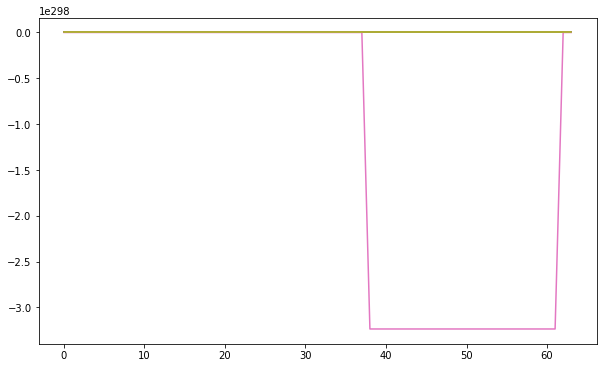

In [38]:
plt.plot(pd.DataFrame(ddi_denoised['djia index data'][5][3]));

In [20]:
%%capture
def tvt_display(ddi_denoised):
    for key, index_name in enumerate(ddi_denoised):
        pdf = PdfPages('{} tvt split denoised visual.pdf'.format(index_name))
        for index,value in enumerate(dict_dataframes_index[index_name]): 
            fig, axes= plt.subplots(1, 3,constrained_layout=False,figsize=(12,4))
            fig.suptitle('{}, period: {}'.format(index_name,value))
            fig.subplots_adjust(top=0.88)
            
            axes[0].set_title('Train')
            axes[0].plot(ddi_denoised[index_name][value][1],label='denoised train data')
            #axes[0].plot(ddi_scaled[index_name][value][1].values,alpha=0.5, label='train data')

            axes[1].set_title('Validate')
            axes[1].plot(ddi_denoised[index_name][value][2],label='denoised validate data')
            #axes[1].plot(ddi_scaled[index_name][value][2].values,alpha=0.5,label='validate data')

            axes[2].set_title('Test')
            axes[2].plot(ddi_denoised[index_name][value][3],label='denoised test data')
            #axes[2].plot(ddi_scaled[index_name][value][3].values,alpha=0.5,label='test data')
            
#             handles, labels = plt.gca().get_legend_handles_labels()
#             by_label = OrderedDict(zip(labels, handles))
#             plt.legend(by_label.values(), by_label.keys())

            #plt.tight_layout()
            #plt.show()
            pdf.savefig(fig)
    pdf.close()    
tvt_display(ddi_denoised)    

In [21]:
#X_train.hist();
#X_train_scaled.hist();

In [22]:
#X_val.hist();
#X_val_scaled.hist();

In [23]:
#X_test.hist();
#X_test_scaled.hist();

In [24]:
##plt.plot(X_train_scaled);

In [25]:
#plt.plot(waveletSmooth(X_train_scaled));

In [26]:
#plt.plot(waveletSmooth(X_val_scaled));

In [27]:
#plt.plot(waveletSmooth(X_test_scaled));

In [28]:
#plt.plot(scaler.inverse_transform(X_train_scaled));

In [29]:
#plt.plot(X_train_scaled);